In [1]:
import torch
from torchvision.io import read_image
from torchvision import transforms
from PIL import Image                                 
import torchvision.transforms.functional as TF       
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir

In [2]:
!unzip imgs.zip

Archive:  imgs.zip
   creating: imgs/
  inflating: imgs/template0_box.jpg  
  inflating: imgs/template10_duck.jpg  
  inflating: imgs/template11_duck.jpg  
  inflating: imgs/template12_flowers.jpg  
  inflating: imgs/template13_flowers.jpg  
  inflating: imgs/template14_flowers.jpg  
  inflating: imgs/template15_flowers.jpg  
  inflating: imgs/template16_flowers.jpg  
  inflating: imgs/template17_flowers.jpg  
  inflating: imgs/template18_cat.jpg  
  inflating: imgs/template19_cat.jpg  
  inflating: imgs/template1_box.jpg  
  inflating: imgs/template20_cat.jpg  
  inflating: imgs/template21_cat.jpg  
  inflating: imgs/template22_cat.jpg  
  inflating: imgs/template23_cat.jpg  
  inflating: imgs/template24_keyboard.jpg  
  inflating: imgs/template25_keyboard.jpg  
  inflating: imgs/template26_keyboard.jpg  
  inflating: imgs/template27_keyboard.jpg  
  inflating: imgs/template28_house.jpg  
  inflating: imgs/template29_house.jpg  
  inflating: imgs/template2_box.jpg  
  inflating: imgs/

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


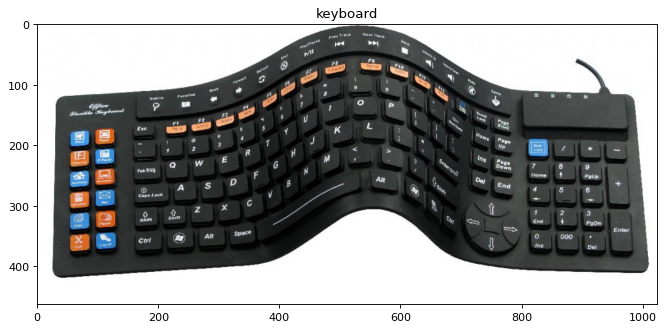

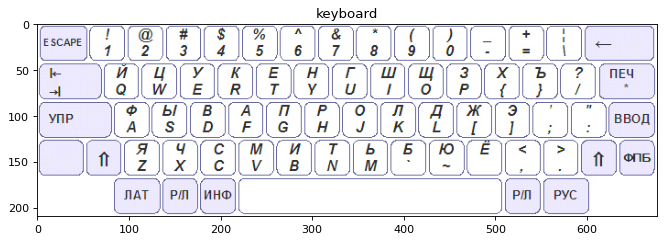

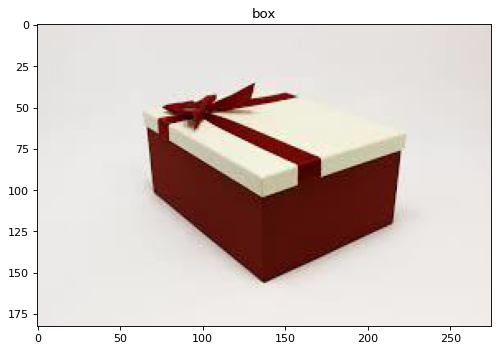

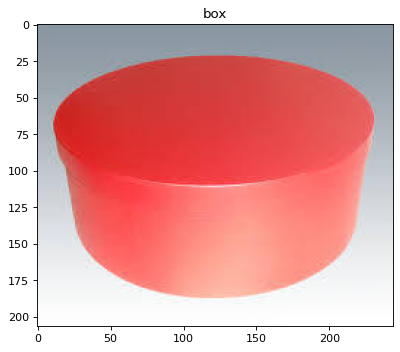

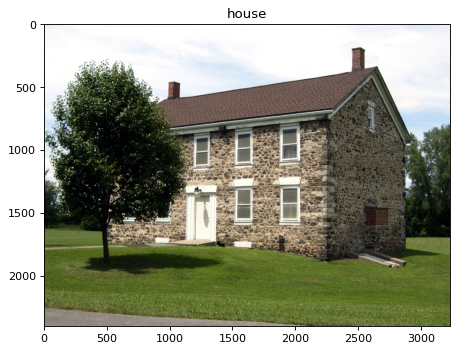

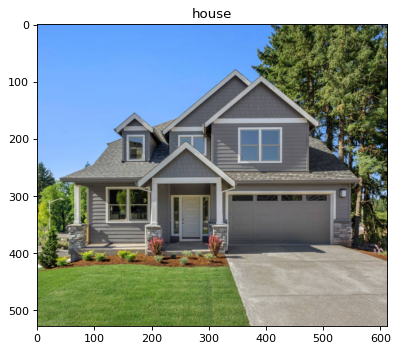

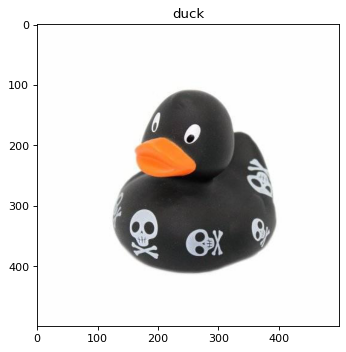

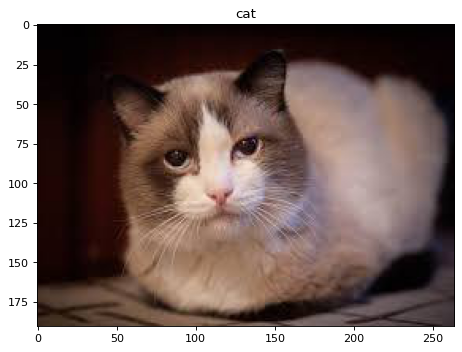

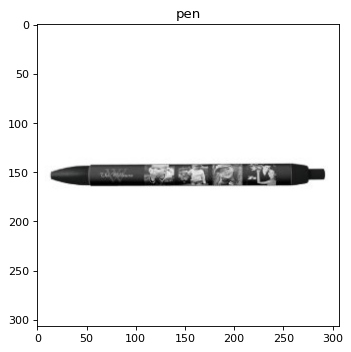

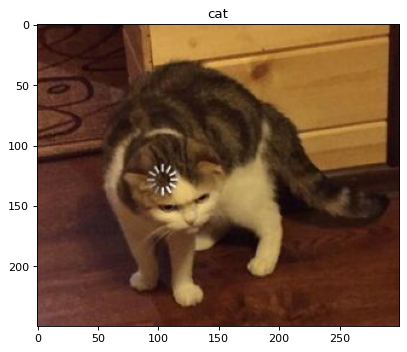

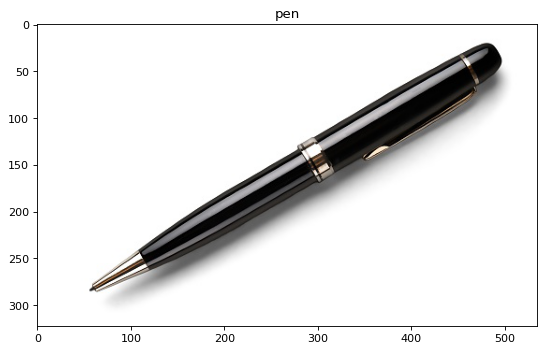

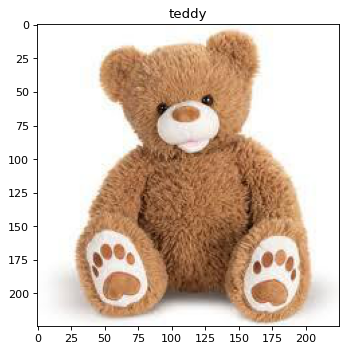

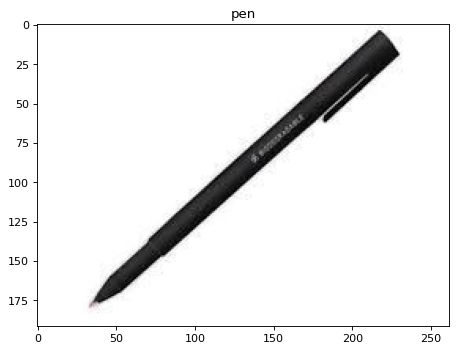

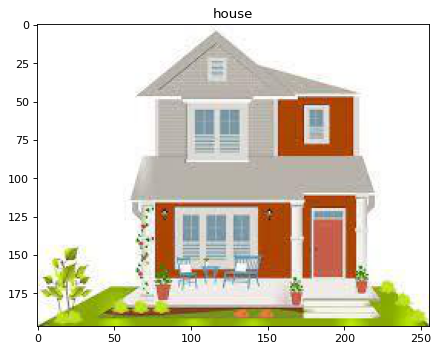

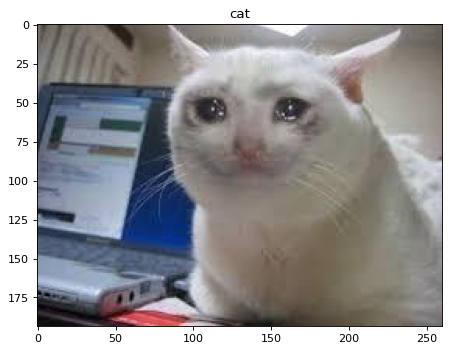

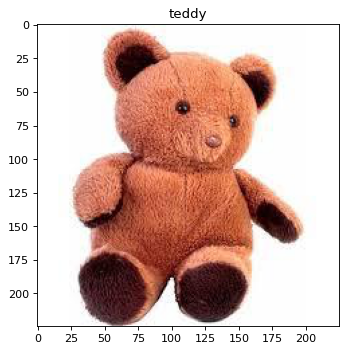

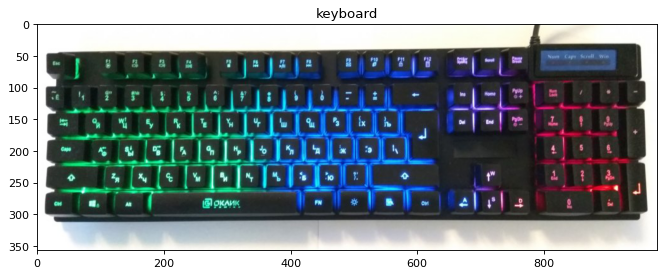

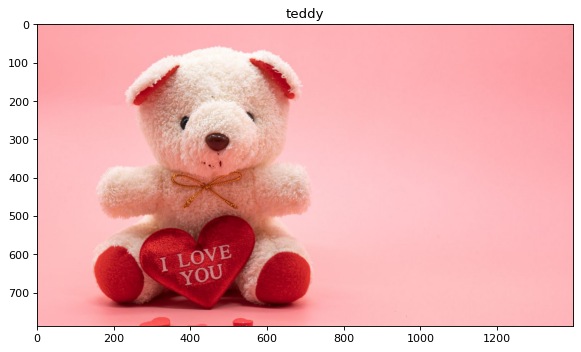

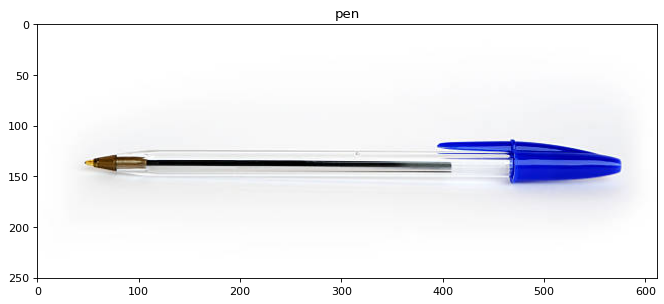

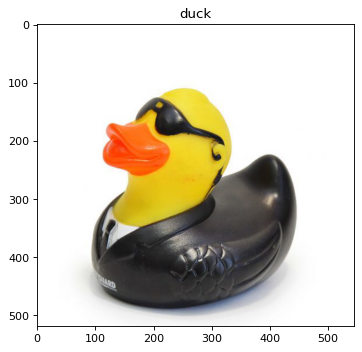

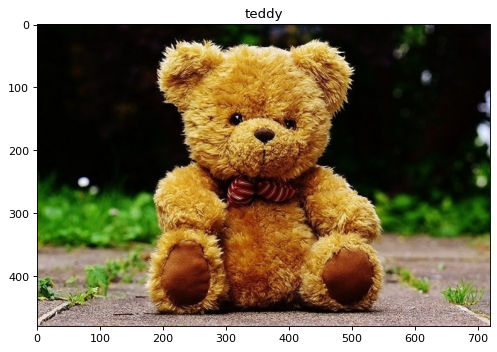

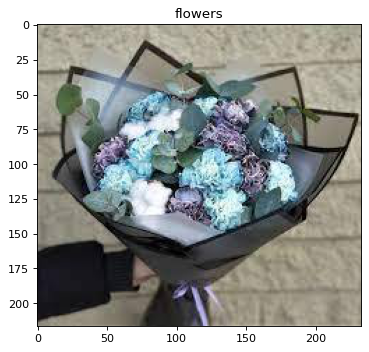

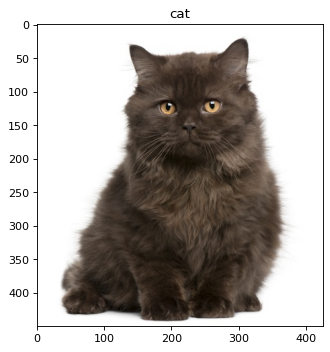

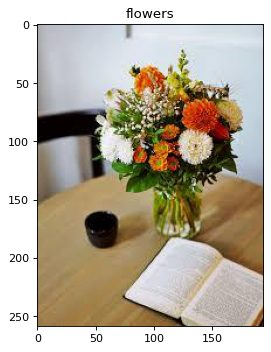

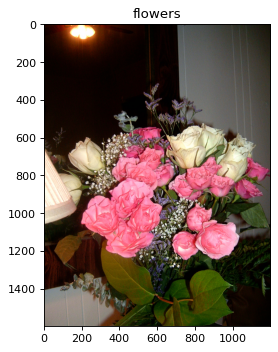

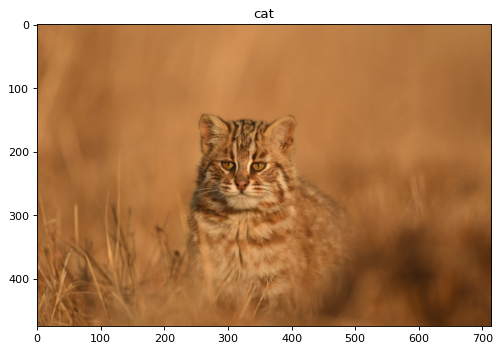

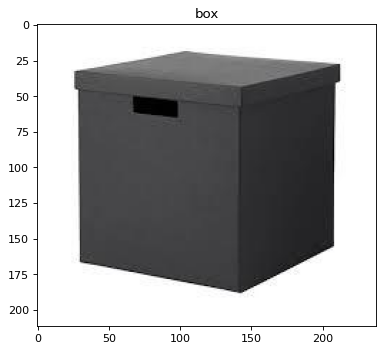

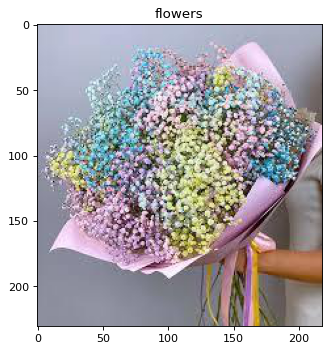

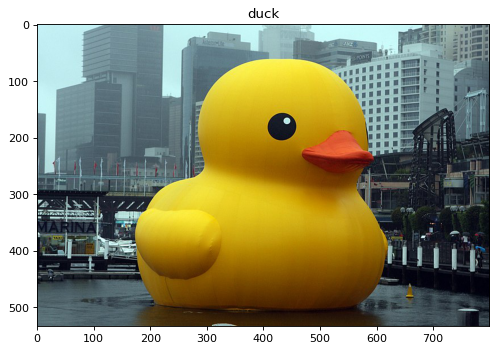

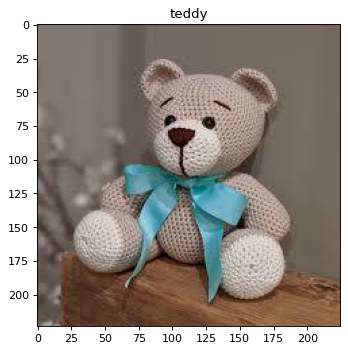

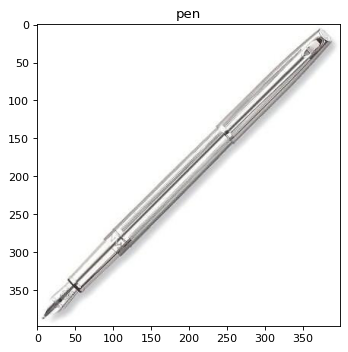

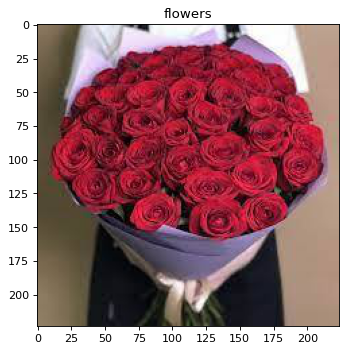

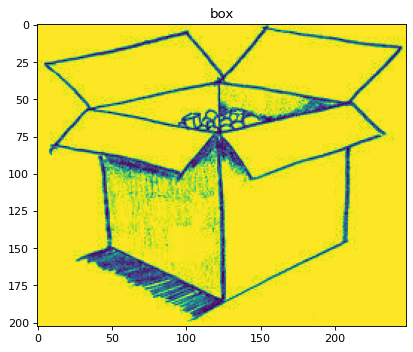

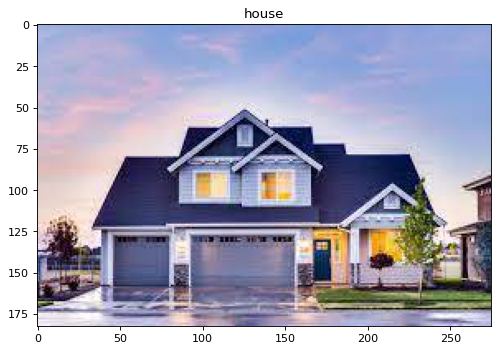

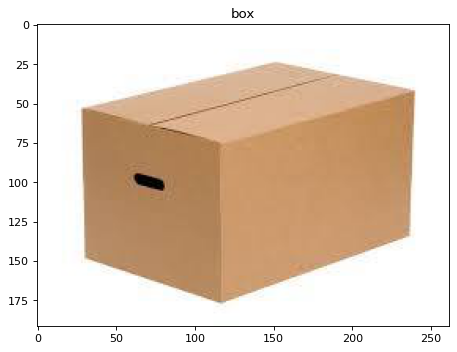

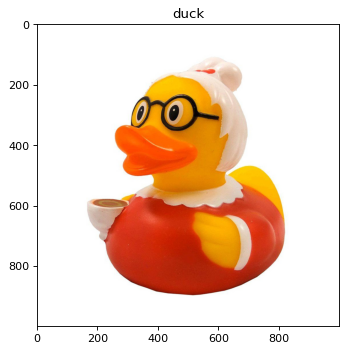

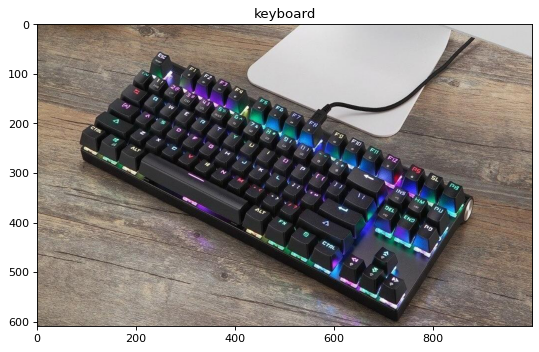

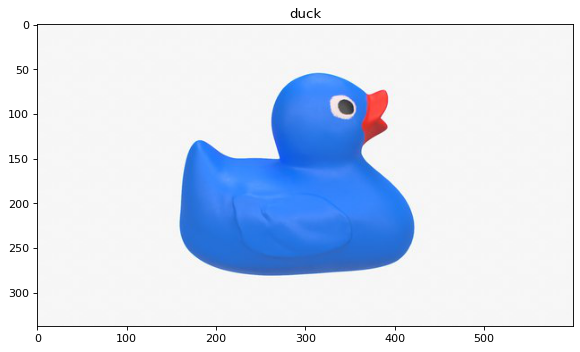

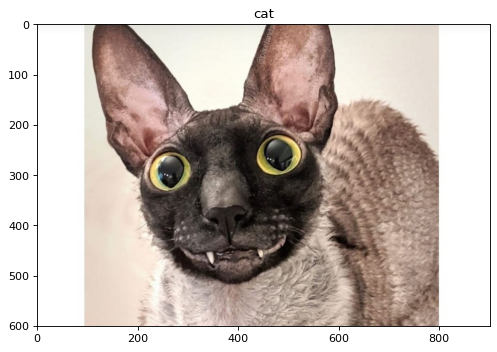

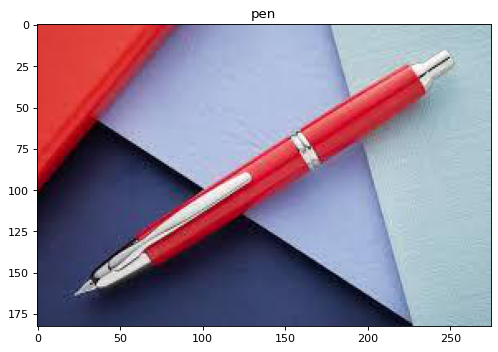

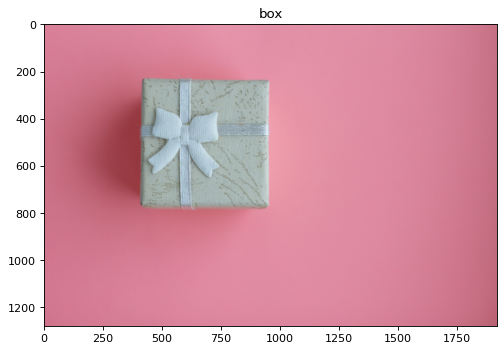

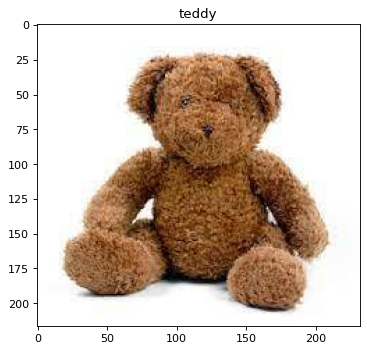

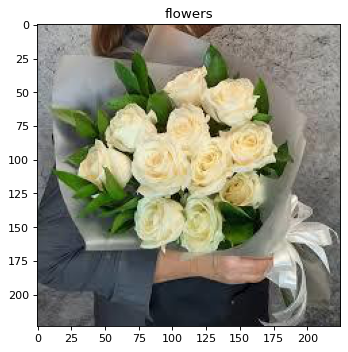

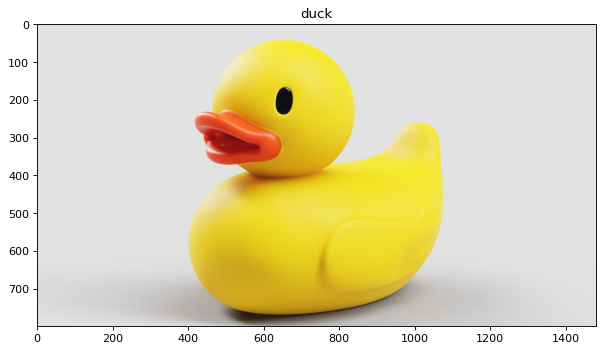

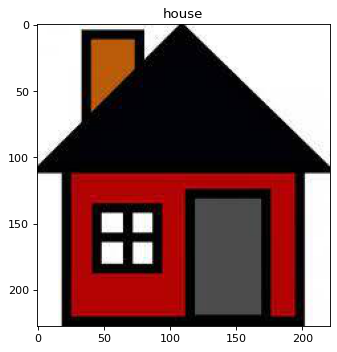

In [4]:
folder_dir = "/content/imgs"
for image in os.listdir(folder_dir):
      if (image.endswith(".jpg")):
        img = plt.imread(folder_dir+'/'+image)
        plt.figure(figsize=(10,5),dpi=80)
        plt.title(image[image.find('_')+1:image.find('.')])
        plt.imshow(img)
        plt.show()

In [5]:
def get_acc(model):
  folder_dir = "/content/imgs"
  top_5_acc_num = 0 
  top_1_acc_num = 0 
  num_of_pics = 0
  errors = 0
  for image in os.listdir(folder_dir):
      try:
        num_of_pics = num_of_pics + 1
        if (image.endswith(".jpg")):
            img = Image.open(folder_dir+'/'+image)
            list_of_top_5_preds = model(img)
            print(image)
            print(list_of_top_5_preds)
            real_name = (image[image.find('_')+1:image.find('.')])
            if real_name in list_of_top_5_preds:
                top_5_acc_num = top_5_acc_num + 1
            if real_name==list_of_top_5_preds[0]:
                top_1_acc_num = top_1_acc_num + 1
      except RuntimeError:
          errors += 1
          print(f"LOL {errors}")
  return top_5_acc_num/num_of_pics , top_1_acc_num/num_of_pics

### ResNet50

In [6]:
from torchvision.models import resnet50, ResNet50_Weights

In [7]:
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model.eval()
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
def resnet(img):
  image = preprocess(img).unsqueeze(0)  

  if torch.cuda.is_available():
    image = image.to('cuda')
    model.to('cuda')
        
  prediction = model(image).squeeze(0).softmax(0)
  n = 5
  class_id = torch.topk(prediction.flatten(), n).indices
  cat_names = []
  for i in range(n):
    score = prediction[class_id[i]].item()
    category_name = weights.meta["categories"][class_id[i]]
    print(f"{category_name}: {100 * score:.1f}%")
    cat_names.append(category_name)
  return cat_names

In [9]:
%%time
t_5_acc, t_1_acc = get_acc(resnet)
print(f'Top 5 accuracy:{np.round(t_5_acc,3)}, Top 1 accuracy:{np.round(t_1_acc,3)}')

space bar: 59.9%
typewriter keyboard: 27.1%
computer keyboard: 9.0%
hand-held computer: 2.7%
mouse: 0.9%
template24_keyboard.jpg
['space bar', 'typewriter keyboard', 'computer keyboard', 'hand-held computer', 'mouse']
crossword puzzle: 60.7%
remote control: 10.7%
computer keyboard: 7.5%
cellular telephone: 7.1%
space bar: 4.7%
template25_keyboard.jpg
['crossword puzzle', 'remote control', 'computer keyboard', 'cellular telephone', 'space bar']
mousetrap: 45.4%
letter opener: 13.0%
nail: 7.3%
plane: 5.8%
pedestal: 3.1%
template1_box.jpg
['mousetrap', 'letter opener', 'nail', 'plane', 'pedestal']
bucket: 17.6%
measuring cup: 17.4%
pencil sharpener: 15.2%
mixing bowl: 6.2%
beaker: 5.2%
template3_box.jpg
['bucket', 'measuring cup', 'pencil sharpener', 'mixing bowl', 'beaker']
tile roof: 19.0%
palace: 10.0%
flagpole: 8.7%
beacon: 7.9%
patio: 7.0%
template31_house.jpg
['tile roof', 'palace', 'flagpole', 'beacon', 'patio']
boathouse: 29.9%
mobile home: 16.6%
patio: 12.9%
picket fence: 8.2%
wi

In [10]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.1 GB
Cached:    0.2 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [11]:
print(round(torch.cuda.max_memory_allocated()/1024**3,1), 'GB')
if device == 'cuda':
    torch.cuda.reset_max_memory_allocated()

0.2 GB


### VGG19

In [12]:
from torchvision.models import vgg19
from torchvision.models.vgg import VGG19_Weights

In [13]:
weights_vgg19 = VGG19_Weights.IMAGENET1K_V1
model = vgg19(weights=weights_vgg19)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [14]:
def vgg19(image): 
  image = preprocess(image)          
  img = image.unsqueeze(0)   
  if torch.cuda.is_available():
    img = img.to('cuda')
    model.to('cuda')
  prediction = model(img).squeeze(0).softmax(0)
  n = 5
  cat_names = []
  class_id = torch.topk(prediction.flatten(), n).indices
  for i in range(n):
    score = prediction[class_id[i]].item()
    category_name = weights.meta["categories"][class_id[i]]
    print(f"{category_name}: {100 * score:.1f}%")
    cat_names.append(category_name)
  return cat_names

In [15]:
%%time
t_5_acc, t_1_acc = get_acc(vgg19)
print(f'Top 5 accuracy:{np.round(t_5_acc,3)}, Top 1 accuracy:{np.round(t_1_acc,3)}')

space bar: 59.2%
computer keyboard: 21.7%
typewriter keyboard: 8.9%
hand-held computer: 7.2%
mouse: 1.2%
template24_keyboard.jpg
['space bar', 'computer keyboard', 'typewriter keyboard', 'hand-held computer', 'mouse']
space bar: 47.3%
computer keyboard: 19.3%
typewriter keyboard: 8.2%
crossword puzzle: 3.8%
remote control: 1.9%
template25_keyboard.jpg
['space bar', 'computer keyboard', 'typewriter keyboard', 'crossword puzzle', 'remote control']
crate: 50.7%
binder: 20.3%
mousetrap: 6.4%
maze: 3.9%
carton: 3.8%
template1_box.jpg
['crate', 'binder', 'mousetrap', 'maze', 'carton']
mixing bowl: 36.7%
croquet ball: 8.8%
sunscreen: 7.4%
pencil sharpener: 5.7%
face powder: 4.4%
template3_box.jpg
['mixing bowl', 'croquet ball', 'sunscreen', 'pencil sharpener', 'face powder']
flagpole: 15.1%
patio: 13.2%
lawn mower: 10.7%
library: 7.4%
barrow: 6.8%
template31_house.jpg
['flagpole', 'patio', 'lawn mower', 'library', 'barrow']
mobile home: 61.5%
boathouse: 15.4%
patio: 10.7%
window screen: 2.8%


In [16]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.5 GB
Cached:    0.7 GB


In [17]:
print(round(torch.cuda.max_memory_allocated()/1024**3,1), 'GB')
if device == 'cuda':
    torch.cuda.reset_max_memory_allocated()

0.6 GB


### AlexNet

In [18]:
from torchvision.models import alexnet, AlexNet_Weights

In [19]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
model = alexnet(weights_alexnet)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [20]:
def alexnet(image): 
  image = preprocess(image)         
  img = image.unsqueeze(0) 
  if torch.cuda.is_available():
    img = img.to('cuda')
    model.to('cuda')
  prediction = model(img).squeeze(0).softmax(0)
  n = 5
  cat_names = []
  class_id = torch.topk(prediction.flatten(), n).indices
  for i in range(n):
    score = prediction[class_id[i]].item()
    category_name = weights.meta["categories"][class_id[i]]
    print(f"{category_name}: {100 * score:.1f}%")
    cat_names.append(category_name)
  return cat_names

In [21]:
%%time
t_5_acc, t_1_acc = get_acc(alexnet)
print(f'Top 5 accuracy:{np.round(t_5_acc,3)}, Top 1 accuracy:{np.round(t_1_acc,3)}')

space bar: 45.4%
typewriter keyboard: 27.9%
computer keyboard: 9.2%
electric guitar: 5.6%
mouse: 4.8%
template24_keyboard.jpg
['space bar', 'typewriter keyboard', 'computer keyboard', 'electric guitar', 'mouse']
typewriter keyboard: 52.0%
computer keyboard: 12.7%
jigsaw puzzle: 7.0%
space bar: 3.0%
crossword puzzle: 2.6%
template25_keyboard.jpg
['typewriter keyboard', 'computer keyboard', 'jigsaw puzzle', 'space bar', 'crossword puzzle']
mousetrap: 17.5%
matchstick: 17.1%
chest: 14.5%
hamper: 8.0%
carton: 7.2%
template1_box.jpg
['mousetrap', 'matchstick', 'chest', 'hamper', 'carton']
mixing bowl: 49.3%
soup bowl: 10.9%
bucket: 8.0%
washbasin: 7.2%
ping-pong ball: 3.7%
template3_box.jpg
['mixing bowl', 'soup bowl', 'bucket', 'washbasin', 'ping-pong ball']
palace: 40.8%
prison: 21.7%
mobile home: 7.6%
monastery: 7.5%
castle: 3.9%
template31_house.jpg
['palace', 'prison', 'mobile home', 'monastery', 'castle']
beacon: 19.6%
solar dish: 15.6%
maypole: 10.4%
patio: 7.9%
boathouse: 6.8%
templ

In [22]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.2 GB
Cached:    0.7 GB


In [23]:
print(round(torch.cuda.max_memory_allocated()/1024**3,1), 'GB')
if device == 'cuda':
    torch.cuda.reset_max_memory_allocated()

0.6 GB
